# 利用Spark分析出租车打车数据



## 1 数据集简介

本数据集为四川省成都市的出租车GPS记录数据集。该数据集已提前清洗完成，仅提取了原始数据集中某一天的部分数据，并且去除了时间段在 0 点至 6 点之间的较少数据。

数据记录了成都市部分出租车在载客时的GPS位置和时间等信息，数据记录的格式为 CSV 格式。

该数据集中的一条记录如下所示：

1 30.624806 104.136604 211846 对各个字段逐个解释如下：

- TID：出租车的ID。每辆出租车的TID都是唯一的。
- Lat：出租车状态为载客时的纬度。
- Lon：出租车状态为载客时的经度。
- Time：该条记录的时间戳。如 211846 代表 21 点 18 分 46 秒。

# 2 试验步骤

## 2.1 首先查看数据：



In [13]:
import matplotlib.pyplot as plt

In [ ]:
//scala

import org.apache.spark._
import org.apache.spark.sql._
import org.apache.spark.sql.types._
import org.apache.spark.sql.functions._
import org.apache.spark.ml.feature.VectorAssembler
import org.apache.spark.ml.clustering.KMeans

val fieldSchema = StructType(Array(
      StructField("TID", StringType, true),
      StructField("Lat", DoubleType, true),
      StructField("Lon", DoubleType, true),
      StructField("Time", StringType, true)
))

val taxiDF = spark.read.format("csv").option("header","false").schema(fieldSchema).load("/sparkml/wei/taxi.csv")
taxiDF.show()

## 2.2 用特征工程提取有用的特征

In [ ]:
//scala
val columns = Array("Lat","Lon")
val va = new VectorAssembler().setInputCols(columns).setOutputCol("features")
val taxiDF2 = va.transform(taxiDF)
taxiDF2.show()

## 2.3 使用Kmeans对坐标信息进行聚类
设置聚类数为10，使用features列作为输入

In [ ]:
//scala
taxiDF2.cache()
val traintestratio = Array(0.8,0.2)
val Array(traindata,testdata) = taxiDF2.randomSplit(traintestratio,4484)
val km = new KMeans().setK(10).setFeaturesCol("features").setPredictionCol("prediction") .fit(taxiDF2)
val kmresult = km.clusterCenters
val kmRDD1 = spark.sparkContext.parallelize(kmresult)
val kmRDD2 = kmRDD1.map(k=>(k(1),k(0)))
kmRDD2.saveAsTextFile("/sparkml/wei/kmResult")

scala> taxiDF2.cache()
res3: taxiDF2.type = [TID: string, Lat: double ... 3 more fields]

scala> val traintestratio = Array(0.8,0.2)
traintestratio: Array[Double] = Array(0.8, 0.2)

scala> val Array(traindata,testdata) = taxiDF2.randomSplit(traintestratio,4484)
traindata: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [TID: string, Lat: double ... 3 more fields]
testdata: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [TID: string, Lat: double ... 3 more fields]

scala> val km = new KMeans().setK(10).setFeaturesCol("features").setPredictionCol("prediction") .fit(taxiDF2)
2020-01-07 09:18:34,966 WARN clustering.KMeans: The input data is not directly cached, which may hurt performance if its parent RDDs are also uncached.
2020-01-07 09:18:38,312 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
2020-01-07 09:18:38,312 WARN netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
2020-01-07 09:18:46,240 WARN clustering.KMeans: The input data was not directly cached, which may hurt performance if its parent RDDs are also uncached.
km: org.apache.spark.ml.clustering.KMeansModel = kmeans_1b79084981cd

scala> val kmresult = km.clusterCenters
kmresult: Array[org.apache.spark.ml.linalg.Vector] = Array([30.673148494635097,104.07578476841387], [30.72412085030872,103.87397208853098], [30.927353901972033,103.62885306030289], [30.59401354785786,103.98592269758088], [30.635381552525054,104.11394199019651], [30.537256303673082,104.05842847715851], [30.753202695449705,104.13250414652543], [30.627461571635052,104.05898271875064], [30.672885436261897,104.01931668552281], [30.56862618296974,104.30709651618582])

scala> val kmRDD1 = spark.sparkContext.parallelize(kmresult)
kmRDD1: org.apache.spark.rdd.RDD[org.apache.spark.ml.linalg.Vector] = ParallelCollectionRDD[87] at parallelize at <console>:39

scala> val kmRDD2 = kmRDD1.map(k=>(k(1),k(0)))
kmRDD2: org.apache.spark.rdd.RDD[(Double, Double)] = MapPartitionsRDD[88] at map at <console>:39

scala> kmRDD2.saveAsTextFile("/sparkml/wei/kmResult")


## 2.4 使用sql语句对预测结果进行简单分析

其中hour表示所处时段，prediction表示所处区域（跟前面坐标对应），count表示打车次数

In [ ]:
//scala

val prediction = km.transform(testdata)
prediction.createTempView("haha")
val tmpQuery = spark.sql("select substring(Time,0,2) as hour,prediction from haha")
val predictCount = tmpQuery.groupBy("hour","prediction").agg(count("prediction").alias("count")).orderBy(desc("count"))
predictCount.show()
predictCount.write.csv("/sparkml/wei/predictCount.csv")
val busyZones = prediction.groupBy("prediction").count()
busyZones.show()
busyZones.write.csv("/sparkml/wei/busyZones.csv")

## 2.5 数据可视化

然后把hdfs上的文件存到本地

hdfs dfs -ls   /sparkml/wei

hdfs dfs -get  /sparkml/wei/predictCount.csv predictCount.csv

hdfs dfs -get  /sparkml/wei/busyZones.csv predictCount.csv

hdfs dfs -getmerge   /sparkml/wei/kmResult  kmResult.csv



利用正则匹配，将数据变成标准格式：

In [ ]:
#bash

sed 's/.$//' kmResult.csv >> kmResult1.csv        #去除行尾括号
sed 's/^.//' kmResult1.csv  kmResult2.csv           #去除行首括号
sed ':a;N;$!ba;s/\n/|/g'  kmResult2.csv >> kmResult3.csv         #将所有换行符\n替换为分隔符|

运用python解析百度API返回的地址参数,得到统计图形

In [7]:
# !pip install pandas_highcharts

In [19]:
#python
import pandas as pd
import urllib.request
import json

data = pd.read_csv("busyZones.csv",header=None,names=("area","counts"))
pre = pd.read_csv("kmResult2.csv",header=None,names=("lon","lat"))
pre["area"] = pre.index
df = pd.merge(data,pre,on="area",how="left")
df

,area,counts,lon,lat
0,1,1639,103.873972,30.724121
1,6,2923,104.132504,30.753203
2,3,8171,103.985923,30.594014
3,5,4106,104.058428,30.537256
4,9,534,104.307097,30.568626
5,4,27974,104.113942,30.635382
6,8,35689,104.019317,30.672885
7,7,36930,104.058983,30.627462
8,2,705,103.628853,30.927354
9,0,44517,104.075785,30.673148


In [20]:
def foundloc(lon,lat):
    url="http://api.map.baidu.com/geocoder/v2/?location=%f,%f&output=json&ak=Yrf32LVk9DEHOYchZAQlG9nFICRTst5V"%(lat,lon)
    req = urllib.request.urlopen(url)
    res = req.read().decode("utf-8")
    temp = json.loads(res)
    return temp["result"]["formatted_address"]

lon = list(df["lon"])
lat = list(df["lat"])
situation = zip(lon,lat)
situa = []
for i in situation:
    situa.append(foundloc(i[0],i[1])[6:-1])

situa

['温江',
 '金牛区玉垒',
 '武侯区凉港',
 '双流县丽景',
 '龙泉驿',
 '锦江区通盈',
 '青羊区华西',
 '武侯区二环路南3段-18号-附11',
 '都江堰市中大街9',
 '青羊区西玉龙街8-1']

In [23]:
df["name"] = situa
df1 = df[["counts","name"]]
df1 = df1.set_index("name")
df1


,counts
name,
温江,1639
金牛区玉垒,2923
武侯区凉港,8171
双流县丽景,4106
龙泉驿,534
锦江区通盈,27974
青羊区华西,35689
武侯区二环路南3段-18号-附11,36930
都江堰市中大街9,705


In [63]:
#定义自定义字体，中文显示不乱码
import matplotlib 
matplotlib.use('qt5agg') 
from matplotlib.font_manager import * 
import matplotlib.pyplot as plt 

myfont = FontProperties(fname='/usr/share/fonts/opentype/noto/NotoSansCJK-Medium.ttc') 



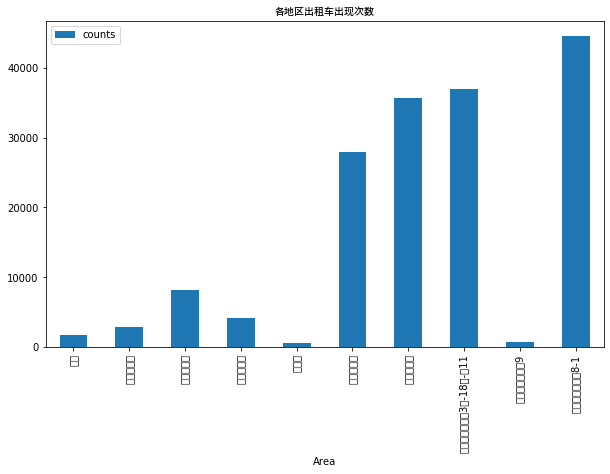

In [78]:
df1.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Area') # add to x-label to the plot
plt.ylabel('')    # add y-label to the plot
plt.title('各地区出租车出现次数',fontproperties=myfont) # add title to the plot

plt.show()

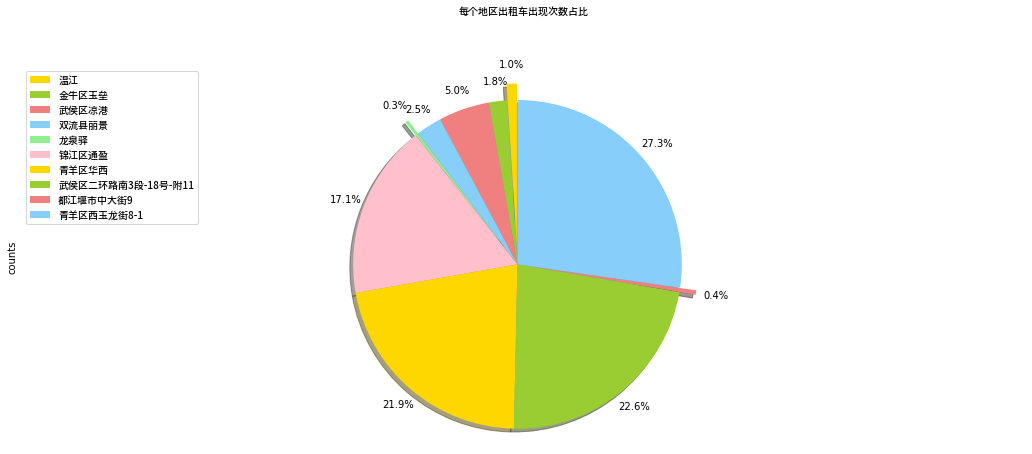

In [64]:
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink']
explode_list = [0.1, 0, 0, 0, 0.1, 0,0, 0, 0.1, 0]            # ratio for each continent with which to offset each wedge.

df1['counts'].plot(
                kind='pie',
                figsize=(18, 7),
                autopct='%1.1f%%', 
                startangle=90, 
                 shadow=True,       
                 labels=None,         # turn off labels on pie chart
                 pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                colors=colors_list,  # add custom colors
                explode=explode_list # 'explode' lowest 3 continents
                            )
# scale the title up by 12% to match pctdistance
plt.title('每个地区出租车出现次数占比', y=1.12,fontproperties=myfont) 

plt.axis('equal') 

# add legend
plt.legend(labels=df1.index, loc='upper left',prop=myfont) 

plt.show()